# Capstone: Part 2

## Executive Summary

Today, E-Mail programs organize emails simply by date received. All emails, be they ones that require an immediate reply, ones that are spam, or ones that are simply informational (and thus can be read anytime) are treated the same. 

Can machine learning be used to ***improve the visibility of action-required emails***, while’s still preserving informational emails and also removing spam?

The ***key metric is recall rate*** from each model, highest is best

After EDA and dimensionality reduction, several models were experimented on to see how they fit the data. Models with high degrees of recall in both the “action” and “non-action” were emphasized. Both tfidf and word vectorization methods were tested, with each being better on alternating models. Ultimately a LinearSVC, with tfidf vectorization was selected, achieving recall rates of 75% on the test data.

After creating these models, they were brought to the iOS platform for testing and mass deployment utilizing Apple’s Core Machine Learning framework.

## Project Diagram
![caption](files/graphics/system-diagram.jpeg)

In [ ]:
# these install's must be run these in this specific order
!pip install pyenv

In [ ]:
!pip install coremltools

In [ ]:
#todo make a use case when the works the best
#todo look at proper nouns
# ask about ther forms of eda to do

In [ ]:
import pandas as pd
from sklearn.svm import LinearSVC
import coremltools
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


## Target Models
This project requires building two models, a spam / not-spam model, plus an “action or informational” model. An extensive labeled dataset was retrieved for spam/not-spam, while a partially usable dataset was retrieved for “action or informational”. That dataset categorized mails into “action required” and not action required. This dataset was used as the basis, and Amazon Mechanical Turk was used to generate a new dataset more precisely suited to project.

In [ ]:
# Nav to datasets directory
%cd
%cd work/Dropbox/ga/capstone/"core ml"/datasets/action
%ls

In [ ]:
df_old_action = pd.read_table("trainSet.txt", header=None)
df_old_action.columns = ["action","content"]

In [ ]:
df_old_action_test = pd.read_table("testSet.txt", header=None)
df_old_action_test.columns = ["action","content"]

In [ ]:
# We will sure cross validation to test the data,
# so we combine the origional "train" and "test" sets
df_old_action = df_old_action.append(df_old_action_test)

In [ ]:
# take a sample to verify the df looks correct
df_old_action.sample(3)

In [ ]:
# match columns with a future dataset
df_old_action.columns = ['final_label', 'email']

In [ ]:
def convert_dataset(row):
    if row['final_label'] == 'No':
        row['final_label'] = 'Neither'
    elif row['final_label'] == 'Yes':
        row['final_label'] = 'Action Required'
    return row

In [ ]:
df_old_action = df_old_action.apply(convert_dataset, axis = 1)

In [ ]:
df_old_action.sample(2)

## Mechanical Turk:
Contributors were asked to label emails as “Action Required”, “Read Later” or “Neither”. They were given the following prompt
“Your name is Sally Beck, these are your emails. You have to decide

1) if these emails ask you to perform some action, like replying or doing something in real life. Or 
2) if the E-Mail can be read later. For example, it just contains general information.”

## Mechanical Truk Diagram
![caption](files/graphics/turk-diagram.jpeg)

### Mechanical Truk Question Example
![caption](files/graphics/turk-example.png)

In [ ]:
# add the truk generated dataset, as many as possible
import glob
list_of_turk_generated_files = glob.glob("/home/jovyan/work/Dropbox/ga/capstone/core ml/datasets/turk/*.csv")

In [ ]:
full_responce_dictionary = {}
def add_responce_to_dict(row):
    key = row['email']
    category = row['Answer']
    if key not in full_responce_dictionary:
        # add key
        full_responce_dictionary[key] = [category]
    else:
        # append the responce to list of responces
        current_list = full_responce_dictionary[key]
        current_list.append(category)
        #print (new_list)
        full_responce_dictionary[key] = current_list

In [ ]:
for file_path in list_of_turk_generated_files:
    batch_df = pd.read_csv(file_path)
    batch_df.apply(add_responce_to_dict, axis = 1)

In [ ]:
#for key in full_responce_dictionary.keys():
#    print (full_responce_dictionary[key])

In [ ]:
# look for mis-matches
# get keys where there is only one opinion
# we use this list to get more
list_of_missing_values = []
for key in full_responce_dictionary.keys():
    values = full_responce_dictionary[key]
    if len(values) == 1:
        list_of_missing_values.append(key)

In [ ]:
print (len(list_of_missing_values))

In [ ]:
def export_list_as_csv(title, list_to_export):
    with open(title, "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        for value in list_to_export:
            writer.writerow([value])   

In [ ]:
export_list_as_csv("missingKeys.csv", list_of_missing_values)

In [ ]:
list_of_disagreeing_rows = []
for key in full_responce_dictionary.keys():
    values = full_responce_dictionary[key]
    if values[0] != values[1]:
        new_dict = {'email': key, 'label_1': values[0], 'label_2': values[1]}
        list_of_disagreeing_rows.append(new_dict)

In [ ]:
with open("dis.csv", "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        for value in list_of_disagreeing_rows:
            writer.writerow([value]) 

In [ ]:
# get convert all the values into a dataframe
list_of_rows = []
for key in full_responce_dictionary.keys():
    values = full_responce_dictionary[key]
    new_dict = {'email': key, 'label_1': values[0], 'label_2': values[1]}
    list_of_rows.append(new_dict)

In [ ]:
df_action = pd.DataFrame(list_of_rows)

In [ ]:
df_action.sample(5)

In [24]:
def get_final_label(row):
    if row['label_1'] == row['label_2']:
        row["final_label"] = row['label_1']
    else:
        row["final_label"] = "disagree"
    return row

In [25]:
df_action = df_action.apply(get_final_label, axis = 1)

In [26]:
df_action.head()

,email,label_1,label_2,final_label
0,I do have a \nfew other thoughts to share that...,Read Later,Read Later,Read Later
1,A decision will be made this evening on whethe...,Read Later,Action Required,disagree
2,"Gerald,\n\nThe ammendment with the mark up we ...",Read Later,Read Later,Read Later
3,Weren't we supposed to be having a meeting on ...,Action Required,Action Required,Action Required
4,Earlier today DPC notified the government of M...,Action Required,Neither,disagree


In [27]:
#todo plot agree and disagree

In [28]:
df_action.groupby("final_label").size()

final_label
Action Required    34
Read Later         30
disagree           38
dtype: int64

In [29]:
df_disagree = df_action[df_action['final_label'] == 'disagree']

In [30]:
df_disagree.shape
# 34 disagree

(38, 4)

In [31]:
df_disagree.to_csv("disagree.csv")

In [32]:
# todo graph how each one disagrees

In [33]:
# fix externally then re import

In [34]:
fixed_label_action_df = pd.read_csv('disagree_labeled.csv')

In [35]:
fixed_label_action_df.head()

,Unnamed: 0,email,label_1,label_2,final_label
0,1,A decision will be made this evening on whethe...,Read Later,Action Required,Action Required
1,4,Earlier today DPC notified the government of M...,Action Required,Neither,Neither
2,6,"As indicated on the voice mail, here is our id...",Action Required,Read Later,Action Required
3,8,"There will be a meeting on Tuesday, Dec. 5th i...",Action Required,Read Later,Action Required
4,11,Hi - I just wanted to give you a quick run dow...,Read Later,Action Required,Read Later


In [36]:
fixed_label_action_df.columns

Index([u'Unnamed: 0', u'email', u'label_1', u'label_2', u'final_label'], dtype='object')

In [37]:
fixed_label_action_df.drop(['Unnamed: 0', 'label_1', 'label_2'], axis = 1, inplace = True)

In [38]:
fixed_label_action_df.head()

,email,final_label
0,A decision will be made this evening on whethe...,Action Required
1,Earlier today DPC notified the government of M...,Neither
2,"As indicated on the voice mail, here is our id...",Action Required
3,"There will be a meeting on Tuesday, Dec. 5th i...",Action Required
4,Hi - I just wanted to give you a quick run dow...,Read Later


In [39]:
fixed_label_action_df.groupby('final_label').size()

final_label
Action Required    10
Neither             2
Read Later         26
dtype: int64

In [40]:
df_agree = df_action[df_action['final_label'] != 'disagree']

In [41]:
final_label_action_df = df_agree

In [42]:
final_label_action_df = final_label_action_df.append(fixed_label_action_df)

In [43]:
final_label_action_df.groupby('final_label').size()

final_label
Action Required    44
Neither             2
Read Later         56
dtype: int64

In [44]:
combined_df = final_label_action_df
combined_df = combined_df.append(df_old_action)

In [45]:
combined_df.drop(['label_1', 'label_2'], axis = 1, inplace = True)

In [46]:
combined_df.sample(3)

,email,final_label
3518,Simply select the type of device you would lik...,Action Required
1992,If you could please let us know where that sta...,Action Required
41,Here are a few questions I would like to submi...,Action Required


In [47]:
X_turk = final_label_action_df["email"]
y_turk = final_label_action_df["final_label"]
X_train_turk, X_test_turk, y_train_turk, y_test_turk = train_test_split(X_turk, y_turk, test_size=0.15, random_state=22)

In [48]:
# use the combined training and test sets and randomly generate the train, test sets
X_combined = combined_df["email"]
y_combined = combined_df["final_label"]
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.15, random_state=22)

In [49]:
combined_df.groupby('final_label').size()

final_label
Action Required    2072
Neither            2623
Read Later           56
dtype: int64

## Cleaning
While lots of data cleaning can happen as a result of manipulating vectorizer parameters, there is one potentially important cleaning aspect for email datasets, people’s names. Unlike, say text messages, email correspondence is more akin to letter writing, with salutations and signatures. Rather than having over 7000 person names (of those, 600 are unique) in the word vector, we will remove all names and replace them with “propername”. Names in the body of emails are identified by the nltk names corpus of “male” and “female” names. In this version of the project, the focus is more on content of emails rather than names and potential networks of the individuals involved. Removing these 600 + names is also attractive from a dimensionality reduction standpoint.

In [50]:
# we use this method the systematicaly test the different models and vectorizers

def make_pipelines_and_test(extra_cleaning_title, X_train, y_train, X_test, y_test):
    count_vec = CountVectorizer()
    #count_vec = CountVectorizer(stop_words="english", min_df = 4)
    
    pipeline_1 = Pipeline([('vect', count_vec),('clf', MultinomialNB())])
    pipeline_2 = Pipeline([('vect', TfidfVectorizer()),('clf', MultinomialNB())])
    pipeline_3 = Pipeline([('vect', count_vec),('clf', LinearSVC())])
    pipeline_4 = Pipeline([('vect', TfidfVectorizer()),('clf', LinearSVC())])
    pipeline_5 = Pipeline([('vect', count_vec),('clf', RandomForestClassifier())])
    pipeline_6 = Pipeline([('vect', TfidfVectorizer()),('clf', RandomForestClassifier())])
    pipelines = [pipeline_3, pipeline_4, pipeline_5, pipeline_6]
    
    #pipeline 5 best recall for NO
    #pipeline 4 best(tied) recal for YES
    
    pipe_dict = {
        "pipeline_1":(pipeline_1, "count_vec, NB, " + extra_cleaning_title),
        "pipeline_2":(pipeline_2, "Tfidf, NB, " + extra_cleaning_title),
        "pipeline_3":(pipeline_3, "count_vec, LinearSVC, " + extra_cleaning_title),
        "pipeline_4":(pipeline_4, "Tfidf, LinearSVC, " + extra_cleaning_title),
        "pipeline_5":(pipeline_5, "count_vec, RandomForestClassifier, " + extra_cleaning_title),
        "pipeline_6":(pipeline_6, "Tfidf, RandomForestClassifier, " + extra_cleaning_title),
    }
    
    highest_recall_score = 0
    highest_recall_model_name = "none"
    
    for pipeline_key in pipe_dict.keys():
        pipeline = pipe_dict[pipeline_key][0]
        pipeline_title = pipe_dict[pipeline_key][1]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        print(pipeline_title)
        report = classification_report(y_test, y_pred)
        print(report)


        precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred)
        
        if recall.sum() > highest_recall_score:
            highest_recall_score = recall.sum()
            highest_recall_model_name = pipeline_title
        
        
        # graphing
        n_groups = len(recall)
        
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.35
        opacity = 0.8
        
        rects1 = plt.bar(index, precision, bar_width,
                 alpha=opacity,
                 color='b',
                 label='precision')
 
        rects2 = plt.bar(index + bar_width, recall, bar_width,
                 alpha=opacity,
                 color='g',
                 label='recall')

        plt.legend()
        
        plt.xlabel('Classes')
        plt.ylabel('Scores')
        plt.title(pipeline_title)
        plt.xticks(index + bar_width, ('Action Required', 'Neither', 'Read Later', ))
 
        plt.tight_layout()
        plt.show()
        
      
        print # just for spacing
    print ("Summed Highest Recall Score: " + str(highest_recall_score))
    print (highest_recall_model_name)
        

## Pre-Cleaning Testing

count_vec, NB, nocleaning-comb
                 precision    recall  f1-score   support

Action Required       0.67      0.77      0.72       311
        Neither       0.78      0.71      0.74       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.73      0.73      0.72       713



/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


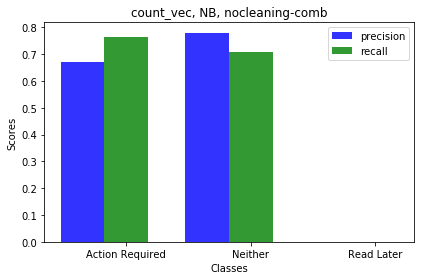


count_vec, LinearSVC, nocleaning-comb
                 precision    recall  f1-score   support

Action Required       0.75      0.70      0.73       311
        Neither       0.77      0.82      0.79       395
     Read Later       1.00      0.14      0.25         7

    avg / total       0.76      0.76      0.76       713



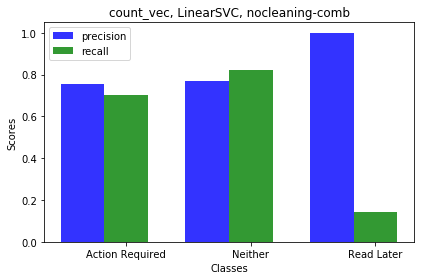


Tfidf, NB, nocleaning-comb
                 precision    recall  f1-score   support

Action Required       0.74      0.59      0.66       311
        Neither       0.72      0.84      0.77       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.72      0.73      0.72       713



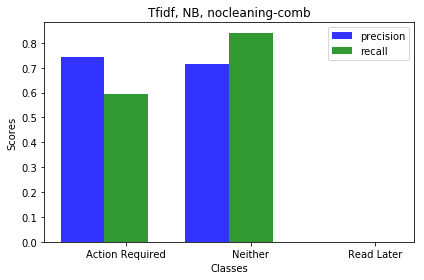


count_vec, RandomForestClassifier, nocleaning-comb
                 precision    recall  f1-score   support

Action Required       0.72      0.73      0.72       311
        Neither       0.77      0.78      0.78       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.74      0.75      0.75       713



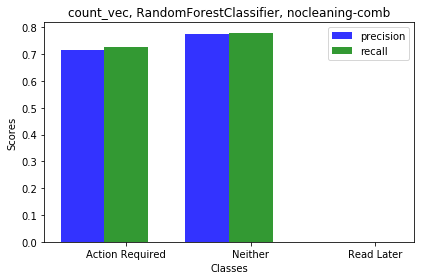


Tfidf, LinearSVC, nocleaning-comb
                 precision    recall  f1-score   support

Action Required       0.77      0.71      0.74       311
        Neither       0.78      0.84      0.81       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.77      0.77      0.77       713



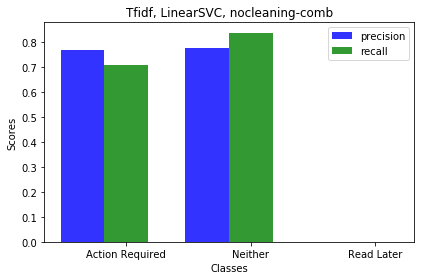


Tfidf, RandomForestClassifier, nocleaning-comb
                 precision    recall  f1-score   support

Action Required       0.70      0.70      0.70       311
        Neither       0.76      0.77      0.77       395
     Read Later       1.00      0.14      0.25         7

    avg / total       0.74      0.74      0.73       713



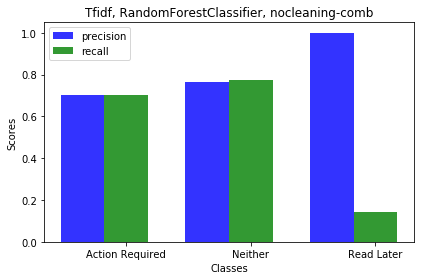


Summed Highest Recall Score: 1.66660658321
count_vec, LinearSVC, nocleaning-comb


In [51]:
make_pipelines_and_test("nocleaning-comb", X_train_combined, y_train_combined, X_test_combined, y_test_combined)

### Best in Non-cleaned Combinded DF
![caption](files/graphics/count_vec, LinearSVC, nocleaning-comb.png)
Summed Highest Recall Score: 1.66660658321

count_vec, LinearSVC, nocleaning-comb

count_vec, NB, nocleaning-turk
                 precision    recall  f1-score   support

Action Required       0.20      0.17      0.18         6
        Neither       0.00      0.00      0.00         0
     Read Later       0.50      0.50      0.50        10

    avg / total       0.39      0.38      0.38        16



/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


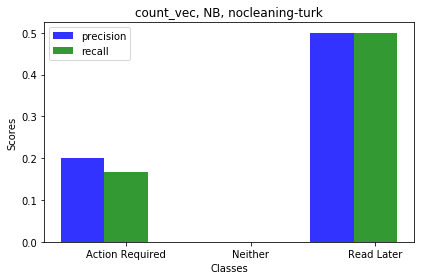


count_vec, LinearSVC, nocleaning-turk
                 precision    recall  f1-score   support

Action Required       0.43      0.50      0.46         6
     Read Later       0.67      0.60      0.63        10

    avg / total       0.58      0.56      0.57        16



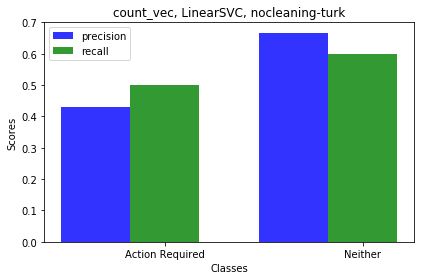


Tfidf, NB, nocleaning-turk
                 precision    recall  f1-score   support

Action Required       0.50      0.17      0.25         6
     Read Later       0.64      0.90      0.75        10

    avg / total       0.59      0.62      0.56        16



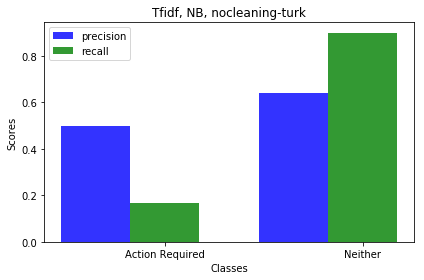


count_vec, RandomForestClassifier, nocleaning-turk
                 precision    recall  f1-score   support

Action Required       0.14      0.17      0.15         6
     Read Later       0.44      0.40      0.42        10

    avg / total       0.33      0.31      0.32        16



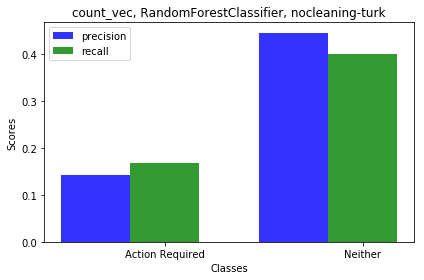


Tfidf, LinearSVC, nocleaning-turk
                 precision    recall  f1-score   support

Action Required       0.25      0.17      0.20         6
     Read Later       0.58      0.70      0.64        10

    avg / total       0.46      0.50      0.47        16



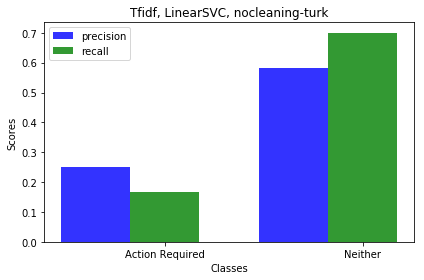


Tfidf, RandomForestClassifier, nocleaning-turk
                 precision    recall  f1-score   support

Action Required       0.36      0.67      0.47         6
     Read Later       0.60      0.30      0.40        10

    avg / total       0.51      0.44      0.43        16



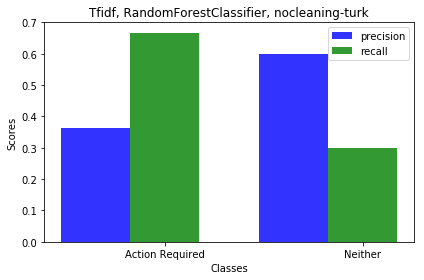


Summed Highest Recall Score: 1.1
count_vec, LinearSVC, nocleaning-turk


In [52]:
make_pipelines_and_test("nocleaning-turk", X_train_turk, y_train_turk, X_test_turk,  y_test_turk)

## Best in Non-cleaned Truk Only
![caption](files/graphics/Tfidf, RandomForestClassifier, nocleaning-turk.png)
Summed Highest Recall Score: 1.13333333333

count_vec, RandomForestClassifier, nocleaning-turk

## Data Cleaning
While lots of data cleaning can happen as a result of manipulating vectorizer parameters, there is one potentially important cleaning aspect for email datasets, people’s names. Unlike, say text messages, email correspondence is more akin to letter writing, with salutations and signatures. Rather than having over 7000 person names (of those, 600 are unique) in the word vector, we will remove all names and replace them with “propername”. Names in the body of emails are identified by the nltk names corpus of “male” and “female” names. In this version of the project, the focus is more on content of emails rather than names and potential networks of the individuals involved. Removing these 600 + names is also attractive from a dimensionality reduction standpoint.

In [53]:
all_string_data = ""

In [54]:
def getAllContentOf (row):
    global all_string_data
    new = all_string_data + row
    all_string_data = new

# get a single string that conatins the bodies of all the dataset emails
combined_df['email'].apply(getAllContentOf)

0      None
2      None
3      None
5      None
7      None
9      None
10     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
20     None
21     None
22     None
23     None
24     None
26     None
27     None
29     None
31     None
32     None
33     None
35     None
39     None
40     None
41     None
42     None
       ... 
962    None
963    None
964    None
965    None
966    None
967    None
968    None
969    None
970    None
971    None
972    None
973    None
974    None
975    None
976    None
977    None
978    None
979    None
980    None
981    None
982    None
983    None
984    None
985    None
986    None
987    None
988    None
989    None
990    None
991    None
Name: email, dtype: object

In [55]:
content_nparray = combined_df["email"].values
content_list = content_nparray.tolist()
content_string = ''.join(content_list)

In [56]:
!pip install nltk
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d names
      Package names is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [57]:
from nltk.corpus import names
all_names = [str(name) for name in names.words("male.txt")] + [str(name) for name in names.words("female.txt")]

In [58]:
# Generate a list of all the names that occure in the emails
all_names = [str(name) for name in names.words("male.txt")] + [str(name) for name in names.words("female.txt")]

In [59]:
len(all_names)

7944

In [68]:
# Look at each email, if it contains a person's name, remove it.
people_in_the_list = []
def find_all_person_names(row):
    content = row['email']
    for word in content.split(' '):
        if word in all_names:
            people_in_the_list.append(word)

def remove_all_person_names(row):
    content = row['email']
    content_list = content.split(' ')
    current_index = 0
    for word in content_list:
        if word in all_names:
            content_list[current_index] = "propername"
        current_index += 1
    
    content_string = ' '.join(content_list)
    row['email'] = content_string
    #print content_string
    return row['email']

In [69]:
combined_df['email'] = combined_df.apply(remove_all_person_names, axis = 1)

In [70]:
# Verify that there are no people names left in the eamil bodies. 
people_in_the_list = []
combined_df.apply(find_all_person_names, axis = 1)

0      None
2      None
3      None
5      None
7      None
9      None
10     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
20     None
21     None
22     None
23     None
24     None
26     None
27     None
29     None
31     None
32     None
33     None
35     None
39     None
40     None
41     None
42     None
       ... 
962    None
963    None
964    None
965    None
966    None
967    None
968    None
969    None
970    None
971    None
972    None
973    None
974    None
975    None
976    None
977    None
978    None
979    None
980    None
981    None
982    None
983    None
984    None
985    None
986    None
987    None
988    None
989    None
990    None
991    None
dtype: object

In [71]:
# Verified, there are no people names left
len(people_in_the_list)

0

## More Pipelines

Re run the pipelines with the cleaned dataset.
the goal is to minimize the number of false positives for both spam and action.
thus the key metric in this action dataset is "recall", we want to maximize it.
LinearSVC modes had more consistent recall rates for Yes’s and No’s, both in the 70s
While Random forest and NB had one recall score in the 60s with another in the 80s.
the LinearSVC, with tfidf was selected because it was most consistent,
with both recall rates of 75%
Furthermore, iOS does not current support NB via sklearn, so it is only shown here for comparison.

In [64]:
X_combined_cleaned = combined_df["email"]
y_combined_cleaned = combined_df["final_label"]

count_vec, NB, cleaned
                 precision    recall  f1-score   support

Action Required       0.67      0.77      0.72       311
        Neither       0.78      0.70      0.74       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.73      0.73      0.72       713



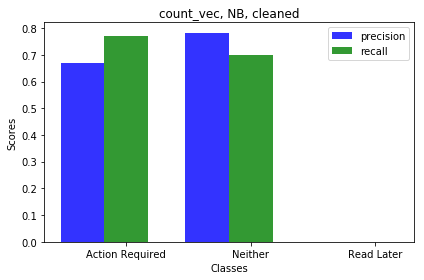


count_vec, LinearSVC, cleaned
                 precision    recall  f1-score   support

Action Required       0.75      0.69      0.72       311
        Neither       0.76      0.82      0.79       395
     Read Later       1.00      0.14      0.25         7

    avg / total       0.76      0.76      0.76       713



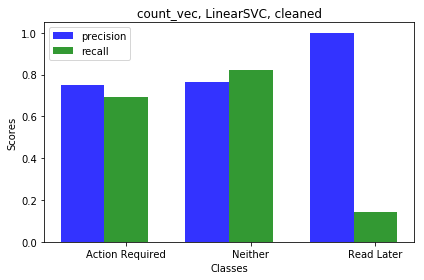


Tfidf, NB, cleaned
                 precision    recall  f1-score   support

Action Required       0.74      0.59      0.66       311
        Neither       0.71      0.84      0.77       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.72      0.72      0.71       713



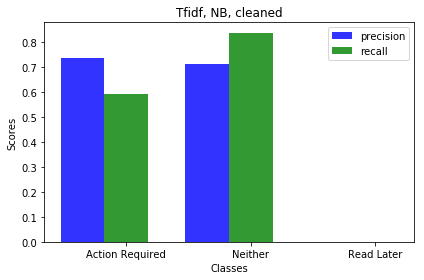


count_vec, RandomForestClassifier, cleaned
                 precision    recall  f1-score   support

Action Required       0.71      0.69      0.70       311
        Neither       0.76      0.79      0.77       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.73      0.74      0.73       713



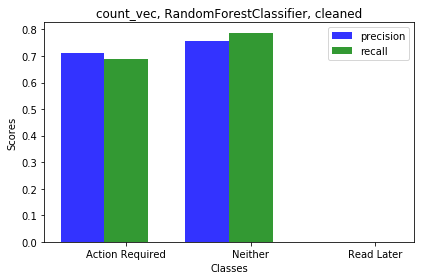


Tfidf, LinearSVC, cleaned
                 precision    recall  f1-score   support

Action Required       0.77      0.71      0.74       311
        Neither       0.78      0.84      0.81       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.77      0.78      0.77       713



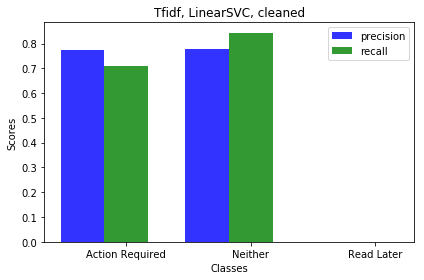


Tfidf, RandomForestClassifier, cleaned
                 precision    recall  f1-score   support

Action Required       0.67      0.76      0.71       311
        Neither       0.78      0.71      0.75       395
     Read Later       0.00      0.00      0.00         7

    avg / total       0.73      0.73      0.72       713



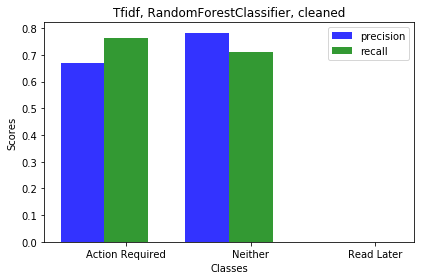


Summed Highest Recall Score: 1.65764406947
count_vec, LinearSVC, cleaned


In [65]:
X_train_combined_cleaned, X_test_combined_cleaned, y_train_combined_cleaned, y_test_combined_cleaned = train_test_split(X_combined_cleaned, y_combined_cleaned, test_size=0.15, random_state=22)
make_pipelines_and_test("cleaned", X_train_combined_cleaned, y_train_combined_cleaned, X_test_combined_cleaned, y_test_combined_cleaned)

## Best in Cleaned Combined Only
![caption](files/graphics/count_vec, LinearSVC, cleaned.png)
Summed Highest Recall Score: 1.65764406947

count_vec, LinearSVC, cleaned

In [66]:
# after examnining several pipelines, we grideasrch for optimal parameters.
params = {
    'vect__stop_words': [None, "english"],
   # 'vect__ngram_range': [(1,2), (2,4), (3,10)],
    'vect__strip_accents': ['unicode', None],
    'vect__analyzer': ['word', 'char', 'char_wb'],
  #  'vect__lowercase' : [True, False],
 #   'vect__max_df': [0.25, 0.5, 1.0],
#    'clf__n_estimators': [5,10,15,20],
    'clf__criterion': ['gini', 'entropy'],
#   'clf__max_features': ['auto', 'log2', None],
 #   'clf__bootstrap': [True, False],
 #   'clf__max_depth': [None, 5, 10, 50]
}
pipeline_5 = Pipeline([('vect', CountVectorizer()),('clf', RandomForestClassifier())])


gs_pipe = GridSearchCV(pipeline_5,
                         param_grid=params,
                         cv = ShuffleSplit(),
                          n_jobs = -1, verbose=1)

# ask about scoring funciton for recall rate

gs_pipe.fit(X_train, y_train.ravel())

#tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
#clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy')
#clf.fit(X_train, y_train)
#pd.DataFrame(clf.cv_results_)



NameError: name 'X_train' is not defined

In [ ]:
gs_pipe.best_score_

In [ ]:
gs_pipe.best_estimator_.named_steps

In [ ]:
gs_pipe_results = pd.DataFrame(gs_pipe.cv_results_)
gs_pipe_results.sort_values('rank_test_score', ascending=True).T

In [ ]:
# predict the action catagory of imput text using the best model and vecotrizer,
# as determined by the pipeline gridsearch

class predict_catagory:
        
    def __init__(self, pages_df_with_cat):
        
        self.model_ready = False
        self.vectorizer = None
        self.X = None
        self.pages_df_with_cat = pages_df_with_cat
        self.df_text = None
        self.model = None
    
    def setup(self):

        from sklearn.feature_extraction.text import CountVectorizer
        import pandas as pd
        # todo update this with gridsearched params
        self.vectorizer = CountVectorizer(stop_words="english", min_df = 4)
        
        #print (self.pages_df_with_cat)
        self.X = self.vectorizer.fit_transform(self.pages_df_with_cat['content'])
        self.df_text = pd.DataFrame(self.X.toarray(), columns=self.vectorizer.get_feature_names())
        self.df_text.index = self.pages_df_with_cat['action']
        #print self.df_text
        model = RandomForestClassifier()
        self.model = model.fit(self.df_text, self.df_text.index)
        
        
        # save the model for iOS Core ML
        words = open('action_words_ordered.txt', 'w')
        for feature in self.vectorizer.get_feature_names():
            words.write(feature.encode('utf-8') + '\n')
        words.close()
       
        coreml_model = coremltools.converters.sklearn.convert(model, "message", 'label')
        coreml_model.save('ActionMessageClassifier.mlmodel')
        
        self.model_ready = True
        
    def find_category_model_ready(self, test_text):
        import pandas as pd
        
        extraxted_text = test_text
        if extraxted_text != "":
            
            self.pages_df_with_cat.loc[len(self.pages_df_with_cat),] = ['unknown', extraxted_text]

            X = self.vectorizer.transform(self.pages_df_with_cat['content'])
            self.df_text = pd.DataFrame(X.toarray(), columns=self.vectorizer.get_feature_names())
            self.df_text.index = self.pages_df_with_cat['action']
            self.df_text = self.df_text.tail(1)

            predicted_category = self.model.predict(self.df_text)

            string_of_category = predicted_category[0]
            
            return string_of_category
        else:
            print ("No text; can't make predictions.")
            return ""
    
    def find_category(self, test_text): 
        if self.model_ready == False:
            self.setup()
        
        predicted_category = self.find_category_model_ready(test_text)
        return predicted_category   

In [ ]:
predict_category_class = predict_catagory(df)
predict_category_class.setup()

In [ ]:
search_text = "As you know, last year's congress attracted over 200 attendees and provided the ideal opportunity for leading institutions to discuss the key issues and latest developments in pricing, trading and risk management strategies for power and gas"
prediction = predict_category_class.find_category(test_text = search_text)
print ('Predicted Category: ' + prediction)

In [ ]:
# or use specific test set as the test set
df_test = pd.read_table("testSet.txt", header=None)
df_test.columns = ["action","content"]
X_train = df["content"]
y_train = df["action"]
X_test = df_test["content"]
y_test = df_test["action"]

In [ ]:
# todo ask named steps feature importance, do that, trees only! Dave says

In [ ]:
# todo are longer emails more likely to be actionable

In [ ]:
#!pip install collective.recipe.libsvm
#!pip install libsvm
#!pip install --upgrade pip
#!pip install -U coremltools
#!pip install coremltools.converters
#!pip install xgboost

In [ ]:
pipeline_5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier())])

pipeline_5.fit(X_train, y_train)

search_text = "Send us an email at support@evite.citysearch.com."
test = pd.Series(search_text)

y_pred = pipeline_5.predict(test)
y_pred